# Libs Import


In [1]:
# %load_ext autoreload
# %autoreload 2
from typing import Optional, Tuple, Literal

import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
from scipy.stats import spearmanr, pearsonr

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platforms', 'cpu')

# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.icnn_modules import ProbStackedICNNImputer, ImputerMetrics, ProbICNNImputerTrainer, ICNNObsDecoder, StandardICNNImputerTrainer
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config, append_params_to_zip, zip_members
 

In [2]:
# ?pub_ready_plots.get_mpl_rcParams
# !pip install pub-ready-plots

In [3]:
import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True

# rc_params['font.size'] = 10
# rc_params['axes.titlesize'] = 12
# rc_params['axes.labelsize'] = 10
# rc_params['legend.fontsize'] = 10

plt.rcParams.update(rc_params)


In [37]:
print('x')

x


# Experiment Defnitions

In [4]:
RESULTS_DIR = 'icnn_results_A'
EXP_DIR = {
    'ICNN_LN': 'experiment_snapshots_mimic_ProbStackedICNN_lognormal',
    'ICNN_NLN': 'experiment_snapshots_mimic_ProbStackedICNN_lognormal_normalised',
    'ICNN_KL': 'experiment_snapshots_mimic_ProbStackedICNN_kl',
    'ICNN_NKL': 'experiment_snapshots_mimic_ProbStackedICNN_kl_normalised',    
    'ICNN_MSE': 'experiment_snapshots_mimic_ProbStackedICNN_mse',
    'ICNN_NMSE': 'experiment_snapshots_mimic_ProbStackedICNN_mse_normalised',
}
PROP_MODELS = ('ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL')
DET_MODELS = ('ICNN_MSE', 'ICNN_NMSE')

EXP = 'ICNN_LN'

# Data Loading

## First Time Loading and Writing to Disk

In [5]:
# tvx = m4aki.TVxAKIMIMICIVDataset.load('/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki.h5')

In [6]:
# obs = [adm.observables  for subject in tvx0.subjects.values() for adm in subject.admissions]
# adm_id = sum(([adm.admission_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])
# subj_id = sum(([subject.subject_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])

In [7]:
# obs_val = np.vstack([obs_i.value for obs_i in obs])
# obs_mask = np.vstack([obs_i.mask for obs_i in obs])
# obs_time = np.hstack([obs_i.time for obs_i in obs])

In [8]:
# tvx0.scheme.obs
# features = list(map(tvx0.scheme.obs.desc.get, tvx0.scheme.obs.codes))

In [9]:
# obs_val = pd.DataFrame(obs_val, columns=features)
# obs_mask = pd.DataFrame(obs_mask.astype(int), columns=features)
# meta = pd.DataFrame({'subject_id': subj_id, 'admission_id': adm_id, 'time': obs_time})


In [10]:
# artificial_mask = obs_mask.copy()
# artificial_mask = obs_mask & np.array(jrandom.bernoulli(jrandom.PRNGKey(0), p=0.8, shape=obs_mask.shape))


In [11]:
# obs_val.to_csv('missingness_data/missingness_vals.csv')
# obs_mask.to_csv('missingness_data/missingness_mask.csv')
# meta.to_csv('missingness_data/meta.csv')
# artificial_mask.to_csv('missingness_data/missingness_artificial_mask.csv')


## Later Loading from Disk

In [12]:
obs_val = pd.read_csv('missingness_data/missingness_vals.csv', index_col=[0])
obs_mask = pd.read_csv('missingness_data/missingness_mask.csv', index_col=[0])
artificial_mask = pd.read_csv('missingness_data/missingness_artificial_mask.csv', index_col=[0])
meta = pd.read_csv('missingness_data/meta.csv', index_col=[0])


## Split

In [13]:
split_ratio = 0.7
seed = 0
indices = jrandom.permutation(jrandom.PRNGKey(seed), len(obs_val))
train_idx = indices[:int(split_ratio * len(indices))]
test_idx = indices[int(split_ratio * len(indices)):]

obs_val_train = jnp.array(obs_val.iloc[train_idx].to_numpy())
obs_mask_train = jnp.array(obs_mask.iloc[train_idx].to_numpy())
art_mask_train =  jnp.array(artificial_mask.iloc[train_idx].to_numpy())

obs_val_test = jnp.array(obs_val.iloc[test_idx].to_numpy())
obs_mask_test = jnp.array(obs_mask.iloc[test_idx].to_numpy())
art_mask_test =  jnp.array(artificial_mask.iloc[test_idx].to_numpy())

# Model Configuration

In [14]:

def models(e):
    pmodels = {k: ProbStackedICNNImputer(observables_size=obs_mask.shape[1], state_size = 0, optax_optimiser_name='polyak_sgd',  
                                         positivity='abs', hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
               for k in PROP_MODELS}
    dmodels =  {k: ICNNObsDecoder(observables_size=obs_mask.shape[1], state_size = 0, optax_optimiser_name='polyak_sgd',
                                  positivity='abs', hidden_size_multiplier=3, depth=5, key=jrandom.PRNGKey(0)) 
                for k in DET_MODELS}
    return (pmodels | dmodels)[e]
    
def trainers(e):
    return {
        'ICNN_LN': ProbICNNImputerTrainer(loss='log_normal'),
        'ICNN_NLN': ProbICNNImputerTrainer(loss='log_normal', loss_feature_normalisation=True),
        'ICNN_KL': ProbICNNImputerTrainer(loss='kl_divergence'),
        'ICNN_NKL': ProbICNNImputerTrainer(loss='kl_divergence', loss_feature_normalisation=True),
        'ICNN_MSE': StandardICNNImputerTrainer(),
        'ICNN_NMSE': StandardICNNImputerTrainer(loss_feature_normalisation=True)
    }[e]

model = models(EXP)
trainer = trainers(EXP)

# Training

## ICNN Training

In [ ]:
lr=1e-3
steps=10000
train_batch_size=256
test_batch_size=1024
# train_batch_size=1
# test_batch_size=1
eval_frequency = 10
model_snapshot_frequency = 100

optim = optax.novograd(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
data_train = (obs_val_train, obs_mask_train, art_mask_train)
data_test = (obs_val_test, obs_mask_test, art_mask_test)

In [ ]:
train_batches = trainer.dataloader(data_train, train_batch_size, key=jrandom.PRNGKey(0))
test_batches = iter(trainer.dataloader(data_test, train_batch_size, key=jrandom.PRNGKey(0)))
train_history = defaultdict(list)
test_history = defaultdict(list)
model_snapshots = {}

In [ ]:
progress = tqdm(range(steps))

for step, batch_train in zip(progress, train_batches):
    start = time.time()
    (train_loss, train_aux), model, opt_state = trainer.make_step(model, optim, opt_state, *batch_train)
    r2_vec =  trainer.model_r_squared(model, *batch_train)
    r2_vec_rank = trainer.model_r_squared_ranked_prob(model, *batch_train, k=5)
    r2_vec = np.array(r2_vec)
    train_nsteps = int(sum(train_aux.n_steps) / len(train_aux.n_steps))
    train_history['R2'].append(r2_vec)
    train_history['R2_rank5'].append(r2_vec_rank)
    train_history['loss'].append(train_loss)
    train_history['n_opt_steps'].append(train_nsteps)
    
    end = time.time()
    if (step % eval_frequency) == 0 or step == steps - 1:
        batch_test = next(test_batches)
        test_loss, _ = trainer.loss(model, *batch_test)
        r2_vec_test = trainer.model_r_squared(model, *batch_test)
        r2_vec_rank_test = trainer.model_r_squared_ranked_prob(model, *batch_test, k=10)
        r2_vec_test = np.array(r2_vec_test)
        test_history['loss'].append(test_loss)
        test_history['R2'].append(r2_vec_test)
        test_history['R2_rank10'].append(r2_vec_rank_test)

    if (step % model_snapshot_frequency) == 0 or step == steps - 1:
        model_snapshots[step] = model
        append_params_to_zip(model, f'step{step:04d}.eqx', f'{EXP_DIR[EXP]}/params.zip')

    progress.set_description(f"Trn-L: {train_loss:.3f}, Trn-R2: ({np.nanmax(r2_vec_rank):.2f}, {np.nanmin(r2_vec_rank):.2f}, {np.nanmean(r2_vec_rank):.2f}, {np.nanmedian(r2_vec_rank):.2f}),  Trn-N-steps: {train_nsteps}, " 
                             f"Tst-L:  {test_loss:.3f}, Tst-R2:  ({np.nanmax(r2_vec_rank_test):.2f}, {np.nanmin(r2_vec_rank_test):.2f}, {np.nanmean(r2_vec_rank_test):.2f}, {np.nanmedian(r2_vec_rank_test):.2f}), "
                             f"Computation time: {end - start:.2f}, ")
                            

In [ ]:
# zip_members(f'{EXP_DIR}/params.zip')

### Dump Training Statistics

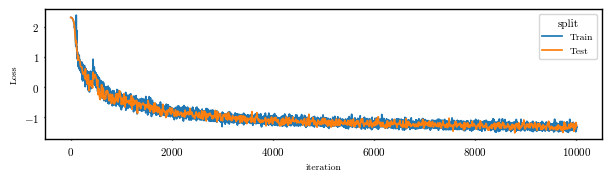

In [17]:
# FIRST TIME - BEGIN 

# train_stats = pd.DataFrame(train_history)
# test_stats = pd.DataFrame(test_history)

# train_stats['split'] = 'Train'
# train_stats['iteration'] = train_stats.index + 1
# test_stats['split'] = 'Test'
# test_stats['iteration'] = (test_stats.index * eval_frequency) + 1
# training_stats = pd.concat([train_stats, test_stats])
# training_stats_melted = pd.melt(training_stats, value_vars=['loss'], id_vars=['split', 'iteration'], value_name='Loss')
# training_stats_melted = training_stats_melted.astype({'Loss': float})

# training_stats.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv')  
# training_stats_melted.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv')  

# FIRST TIME - END 


# LATER TIMES
training_stats = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv', index_col=[0])  
training_stats_melted = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv', index_col=[0])  



g2 = sns.lineplot(data=training_stats_melted, x="iteration", y="Loss", hue="split")
g2.get_figure().set_size_inches(fig_width_in, fig_height_in)
g2.get_figure().savefig(f"{RESULTS_DIR}/{EXP}_training_stats.pdf")

## Sklearn Training

In [18]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

sklearn_imputers =  {
    'zero_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    'mean_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn_imputer': lambda: KNNImputer(missing_values=np.nan),
    'iter_imputer': lambda: IterativeImputer(
        missing_values=np.nan,
        add_indicator=False,
        random_state=0,
        n_nearest_features=5,
        max_iter=5,
        sample_posterior=True,
    )
}

sklearn_trained_imputers = {k: v().fit(np.where(obs_mask_train, obs_val_train, np.nan)) for k, v in sklearn_imputers.items()} 

# Metrics / Results

In [19]:
prediction_mask = (1 - art_mask_test) * obs_mask_test
feature2index =  dict(zip(obs_val.columns, range(len(obs_val.columns))))
n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)
n_test = ((1 - art_mask_test) * obs_mask_test).sum(axis=0)
n_train_measured = obs_mask_train.sum(axis=0)
missingness = 1 - obs_mask.mean(axis=0)
validation_missingness = 1 - pd.DataFrame(art_mask_test, columns=obs_mask.columns).mean(axis=0)

In [20]:
variable_map = {'blood_chemistry.albumin': 'Albumin',  'blood_chemistry.aniongap': 'Aniongap',  'blood_chemistry.bicarbonate': 'Bicarbonate',  'blood_chemistry.bun': 'Urea Nitrogen',  'blood_chemistry.calcium': 'Calcium',  'blood_chemistry.chloride': 'Chloride',  'blood_chemistry.creatinine': 'Creatinine',  'blood_chemistry.globulin': 'Globulin',  'blood_chemistry.glucose': 'Glucose',  'blood_chemistry.potassium': 'Potassium',  'blood_chemistry.sodium': 'Sodium',  'blood_chemistry.total_protein': 'Protein Total',  'blood_diff.atypical_lymphocytes': 'Atypical Lymphocytes',  'blood_diff.bands': 'Bands (%)',  'blood_diff.basophils': 'Basophils',  'blood_diff.basophils_abs': 'Abs Basophils',  'blood_diff.eosinophils': 'Eosinophils',  'blood_diff.eosinophils_abs': 'Abs Eosinophils',  'blood_diff.immature_granulocytes': 'Immature Granulocytes',  'blood_diff.lymphocytes': 'Lymphocytes',  'blood_diff.lymphocytes_abs': 'Abs Lymphocytes',  'blood_diff.metamyelocytes': 'Metamyelocytes',  'blood_diff.monocytes': 'Monocytes',  'blood_diff.monocytes_abs': 'Abs Monocytes',  'blood_diff.neutrophils': 'Neutrophils',  'blood_diff.neutrophils_abs': 'Abs Neutrophil',  'blood_diff.nrbc': 'NRBC',  'blood_gas.aado2': 'AaDO2',  'blood_gas.aado2_calc': 'AaDO2_calc',  'blood_gas.baseexcess': 'Base excess',  'blood_gas.bicarbonate': 'Bicarbonate',  'blood_gas.calcium': 'Calcium',  'blood_gas.carboxyhemoglobin': 'Carboxyhemoglobin',  'blood_gas.chloride': 'Chloride',  'blood_gas.fio2': 'FiO2',  'blood_gas.fio2_chartevents': 'FiO2_chartevents',  'blood_gas.glucose': 'Glucose',  'blood_gas.hematocrit': 'Hematocrit',  'blood_gas.hemoglobin': 'Hemoglobin',  'blood_gas.lactate': 'Lactate',  'blood_gas.methemoglobin': 'Methemoglobin',  'blood_gas.pao2fio2ratio': 'pO2/FiO2 ratio',  'blood_gas.pco2': 'pCO2',  'blood_gas.ph': 'pH',  'blood_gas.po2': 'pO2',  'blood_gas.potassium': 'Potassium',  'blood_gas.so2': 'sO2',  'blood_gas.sodium': 'Sodium',  'blood_gas.temperature': 'Temperature',  'blood_gas.totalco2': 'CO2 total',  'cardiac_marker.ck_mb': 'Creatinine Kinase, MB',  'cardiac_marker.ntprobnp': 'NT-proBNP',  'cardiac_marker.troponin_t2': 'Troponin T',  'cbc.hematocrit': 'Hematocrit',  'cbc.hemoglobin': 'Hemoglobin',  'cbc.mch': 'MCH',  'cbc.mchc': 'MCHC',  'cbc.mcv': 'MCV',  'cbc.platelet': 'Platelet',  'cbc.rbc': 'RBC',  'cbc.rdw': 'RDW',  'cbc.wbc': 'WBC',  'coagulation.d_dimer': 'D-Dimer',  'coagulation.fibrinogen': 'Fibrinogen',  'coagulation.inr': 'INR',  'coagulation.pt': 'PT',  'coagulation.ptt': 'PTT',  'coagulation.thrombin': 'Thrombin',  'enzymes.alp': 'ALP',  'enzymes.alt': 'ALT',  'enzymes.amylase': 'Amylase',  'enzymes.ast': 'AST',  'enzymes.bilirubin_direct': 'Bilirubin direct',  'enzymes.bilirubin_indirect': 'Bilirubin indirect',  'enzymes.bilirubin_total': 'Bilirubin total',  'enzymes.ck_cpk': 'CK-CPK',  'enzymes.ck_mb':'CK-MB',  'enzymes.ggt': 'GGT',  'enzymes.ld_ldh': 'ld_ldh',  'icp.icp': 'Intra-cranial Press.',  'inflammation.crp': 'CRP',  'renal_aki.aki_binary': 'AKI (binary)',  'renal_aki.aki_stage_smoothed': 'AKI',  'renal_creat.creat': 'Creatinine',  'renal_out.uo_rt_12hr': 'Urine out 12h',  'renal_out.uo_rt_24hr': 'Urine out 24h',  'renal_out.uo_rt_6hr': 'Urine out 6h',  'sofa.sofa_24hours': 'SOFA',  'vital.dbp': 'Diastolic BP',  'vital.dbp_ni': 'NI-Diastolic BP',  'vital.glucose': 'Glucose',  'vital.heart_rate': 'Heart Rate',  'vital.mbp':  'Mean BP',  'vital.mbp_ni': 'NI Mean BP',  'vital.resp_rate': 'Respiratory Rate',  'vital.sbp': 'Systolic BP',  'vital.sbp_ni':  'NI-Systolic BP',  'vital.spo2': 'SpO2',  'vital.temperature': 'Temperature',  'weight.weight': 'Weight'}

## Metrics Evolution with ICNN Training

In [21]:
# FIRST TIME - BEGIN 

# dataframes = []
# for step, model_snap in tqdm(model_snapshots.items()):
#     with jax.default_device(jax.devices("cpu")[0]):
#         obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#         (X_test_imp, X_test_std), _ = eqx.filter_vmap(model_snap.prob_partial_input_optimise)(obs_test, art_mask_test)
    
#     sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
#     r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                           for t in sigma_threshold]
    
#     r2_test_results = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
#     r2_test_results['sigma_threshold'] = sigma_threshold
#     r2_test_results['step'] = step
#     dataframes.append(r2_test_results)

# r2_iters_test_results = pd.concat(dataframes)
# r2_iters_test_results = pd.melt(r2_iters_test_results, value_vars=list(obs_val.columns), id_vars=['sigma_threshold', 'step'], value_name='R2')

# r2_iters_test_results.to_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv')
# FIRST TIME - END 
# r2_iters_test_results = pd.read_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv', index_col=[0])

In [22]:
# r2_iters_test_results

## Metrics of the Last ICNN Snapshot

In [34]:
model = model.load_params_from_archive(f'{EXP_DIR[EXP]}/params.zip', 'step9999.eqx')

In [35]:
# FIRST TIME - BEGIN 
with jax.default_device(jax.devices("cpu")[0]):
    obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
    (X_test_imp, X_test_std), _ = eqx.filter_vmap(model.prob_partial_input_optimise)(obs_test, art_mask_test)

X_test_imp_df = pd.DataFrame(X_test_imp, columns=obs_val.columns)
X_test_std_df = pd.DataFrame(X_test_std, columns=obs_val.columns)

X_test_imp_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_imp.csv')
X_test_std_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_std.csv')
# FIRST TIME - END 

X_test_imp_df = pd.read_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_imp.csv', index_col=[0])
X_test_std_df = pd.read_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_std.csv', index_col=[0])
X_test_imp = X_test_imp_df.to_numpy()
X_test_std = X_test_std_df.to_numpy()


In [27]:
# FIRST TIME - BEGIN 

# icnn_X_test_se = (X_test_imp_df - np.array(obs_val_test))**2
# icnn_X_test_se = icnn_X_test_se.where(prediction_mask.astype(bool), other=np.nan)
# icnn_X_test_se = pd.melt(icnn_X_test_se, value_vars=list(obs_val.columns), value_name='SE')
# icnn_X_test_se = icnn_X_test_se[icnn_X_test_se.SE.notnull()]
# icnn_X_test_se['Imputer'] = 'ICNN'
# icnn_X_test_se.to_csv(f'{RESULTS_DIR}/{EXP}_X_test_se.csv')

# FIRST TIME - END 
icnn_X_test_se = pd.read_csv(f'{RESULTS_DIR}/{EXP}_X_test_se.csv', index_col=[0])
icnn_X_test_se

FileNotFoundError: [Errno 2] No such file or directory: 'experiment_snapshots_mimic_ProbStackedICNN_lognormal/icnn_X_test_se.csv'

In [30]:
# FIRST TIME - BEGIN 
# SE = (X_test_imp - obs_val_test) ** 2
# SE = jnp.where(prediction_mask, SE, jnp.nan)
# X_test_var = jnp.where(prediction_mask, X_test_std ** 2, jnp.nan)

# se_data = defaultdict(list)
# for i in range(SE.shape[1]):
#     se_data['SE'].extend(np.array(SE[:, i][prediction_mask[:, i].astype(bool)]).tolist())
#     se_data['sigma2'].extend(np.array(X_test_var[:, i][prediction_mask[:, i].astype(bool)]).tolist())
#     se_data['Feature'].extend([obs_val.columns[i]] * int(prediction_mask[:, i].sum()))
    
# se_df = pd.DataFrame(se_data)
# se_df.to_csv(f'{RESULTS_DIR}/{EXP}_se_stats.csv')
# FIRST TIME - END 

# LATER TIMES
se_df = pd.read_csv(f'{RESULTS_DIR}/{EXP}_se_stats.csv', index_col=[0])

In [32]:
# FIRST TIME - BEGIN 

# features_r2 = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp.T, prediction_mask.T)
# features_ss_total = jnp.nansum((obs_val_test - obs_val_test.mean(axis=0))**2, where=prediction_mask, axis=0)
# features_ss_res = (1 - features_r2) * features_ss_total
# features_mse = jnp.where(prediction_mask.sum(axis=0) > 2, features_ss_res / prediction_mask.sum(axis=0), jnp.nan)

# sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
# r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                       for t in sigma_threshold]
# r2_test_thresholded_df = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
# r2_test_thresholded_df['sigma_threshold'] = sigma_threshold

# r2_test_thresholded_melted_df = pd.melt(r2_test_thresholded_df, value_vars=list(obs_val.columns), id_vars=['sigma_threshold'], value_name='R2')


# icnn_features_stats = defaultdict(list)
# n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)

# for feature, feature_df in se_df.groupby('Feature'):
#     icnn_features_stats['Feature'].append(feature)
#     icnn_features_stats['n_training_measured'].append(n_train_measured[feature2index[feature]])
#     icnn_features_stats['n_training_censored'].append(n_train[feature2index[feature]])
#     icnn_features_stats['n_test_censored'].append(n_test[feature2index[feature]])
#     icnn_features_stats['missingness'].append(missingness[feature2index[feature]].item())
#     icnn_features_stats['R2'].append(features_r2[feature2index[feature]].item())
#     icnn_features_stats['MSE'].append(features_mse[feature2index[feature]].item())

#     icnn_features_stats['sigma2_se_spearman'].append(spearmanr(feature_df['SE'], feature_df['sigma2']).statistic)
    
# icnn_features_stats_df = pd.DataFrame(icnn_features_stats)


# r2_test_thresholded_df.to_csv(f'{RESULTS_DIR}/{EXP}_r2_test_thresholded.csv')
# r2_test_thresholded_melted_df.to_csv(f'{RESULTS_DIR}/{EXP}_r2_test_thresholded_melted.csv')
# icnn_features_stats_df.to_csv(f'{RESULTS_DIR}/{EXP}_features_stats.csv')  

# LATER TIMES
# r2_test_thresholded_df = pd.read_csv(f'{RESULTS_DIR}/{EXP}_r2_test_thresholded.csv', index_col=[0])
# r2_test_thresholded_melted_df = pd.read_csv(f'{RESULTS_DIR}/{EXP}_r2_test_thresholded_melted.csv', index_col=[0])
# icnn_features_stats_df = pd.read_csv(f'{RESULTS_DIR}/{EXP}_features_stats.csv', index_col=[0])


In [33]:
spearman_se_sigma_all = spearmanr(se_df['SE'], se_df['sigma2']).statistic
pearson_se_sigma_all = pearsonr(se_df['SE'], se_df['sigma2']).statistic
r2_all = ProbICNNImputerTrainer.r_squared(obs_val_test, X_test_imp, prediction_mask)
ss_total = jnp.nansum((obs_val_test - obs_val_test.mean())**2, where=prediction_mask)
ss_res = (1 - r2_all) * ss_total
mse =  ss_res / prediction_mask.sum()

icnn_global_stats = pd.DataFrame({r'$r_\text{Pearson}(SE, \sigma^2)$': [pearson_se_sigma_all],
                                  r'$r_\text{Spearman}(SE, \sigma^2)$': [spearman_se_sigma_all],
                                  r'$R^2(z, \mu)$': [r2_all],
                                  'MSE': [mse]})
icnn_global_stats.to_csv(f'{RESULTS_DIR}/{EXP}_global_stats.csv')  
icnn_global_stats

NameError: name 'X_test_imp' is not defined

In [ ]:
icnn_features_stats_df.sort_values('R2').tail(15)

In [ ]:
r_classes = [r'$r > 0.3$', r'$r \in (0.1, 0.3]$', r'$r \in (-0.1, 0.1]$', r'$r \leq -0.1$']
R_classes = [r'$R^2 > 0.25$', r'$R^2 \in (0.1, 0.25]$', r'$R^2 \in (-0.1, 0.1]$', r'$R^2 \leq -0.1$']
def classify_r(r):
    if r > 0.3:
        return r_classes[0]
    elif r > 0.1:
        return r_classes[1]
    elif r > -0.1:
        return r_classes[2]
    else:
        return r_classes[3]

def classify_R(R):
    if R > 0.25:
        return R_classes[0]
    elif R > 0.1:
        return R_classes[1]
    elif R > -0.1:
        return R_classes[2]
    else:
        return R_classes[3] 

icnn_features_stats_df[r'$r(\sigma^2, SE)$'] = icnn_features_stats_df.sigma2_se_spearman.map(classify_r)

vars_n300 = icnn_features_stats_df[icnn_features_stats_df.n_test_censored >= 300].Feature
print(len(vars_n300))
icnn_features_stats_df[icnn_features_stats_df.Feature.isin(vars_n300)].sort_values('sigma2_se_spearman').head(30)


In [ ]:
ax = sns.countplot(icnn_features_stats_df[icnn_features_stats_df.Feature.isin(vars_n300)], y=r'$r(\sigma^2, SE)$', order=r_classes)
ax.bar_label(ax.containers[0], fontsize=10);
ax.get_figure().set_size_inches(fig_width_in, fig_height_in)
ax.get_figure().savefig(f"{RESULTS_DIR}/{EXP}_r_sigma_SE.pdf")

## Metrics of Sklearn Models

In [ ]:
# FIRST TIME - BEGIN 
sklearn_imputed_X = {k: v.transform(np.where(art_mask_test, obs_val_test, np.nan)) for k, v in sklearn_trained_imputers.items()} 
for sklearn_name, imputed_X_ in sklearn_imputed_X.items():
    X_test_imp_df = pd.DataFrame(imputed_X_, columns=obs_val.columns)    
    X_test_imp_df.to_csv(f'{RESULTS_DIR}/{sklearn_name}_pred_X_test_imp.csv')
# FIRST TIME - END 


sklearn_imputed_X = {k: pd.read_csv(f'{RESULTS_DIR}/{k}_pred_X_test_imp.csv', index_col=[0]) 
                     for k in sklearn_imputers.keys()} 


In [ ]:
# FIRST TIME - BEGIN 

sklearn_X_test_se = {k: (X_imp_ - np.array(obs_val_test))**2 for k, X_imp_ in sklearn_imputed_X.items()}
sklearn_X_test_se = {k: np.where(prediction_mask.astype(bool), X_test_se, np.nan) for k, X_test_se in sklearn_X_test_se.items()}
sklearn_X_test_se_df = []
for k, X_test_se in sklearn_X_test_se.items():
    X_test_se = pd.DataFrame(X_test_se, columns=obs_val.columns)
    df = pd.melt(X_test_se, value_vars=list(obs_val.columns), value_name='SE')
    df = df[df.SE.notnull()]
    df['Imputer'] = k
    sklearn_X_test_se_df.append(df)

sklearn_X_test_se_df = pd.concat(sklearn_X_test_se_df)
sklearn_X_test_se_df.to_csv(f'{RESULTS_DIR}/sklearn_X_test_se.csv')
# FIRST TIME - END 
sklearn_X_test_se_df = pd.read_csv(f'{RESULTS_DIR}/sklearn_X_test_se.csv', index_col=[0])
sklearn_X_test_se_df

In [ ]:
X_test_se_df = pd.concat([icnn_X_test_se, sklearn_X_test_se_df])
X_test_se_df['group'] = X_test_se_df.variable.str.split('.').map(lambda x: x[0])
X_test_se_df['Feature'] = X_test_se_df.variable.map(variable_map)

In [ ]:
groups = X_test_se_df['group'].unique().tolist()
groups

In [ ]:
X_test_se_df

In [ ]:
# enzymes (except Amylase, Bilirubin indirect, CK-CPK)
# renal_creat
# renal_aki
# renal_out
# sofa

X_test_se_df_selection = X_test_se_df[X_test_se_df.group.isin(['renal_out', 'renal_creat', 'renal_aki', 'sofa'])]

grid = sns.FacetGrid(data=X_test_se_df_selection, col="group", sharex=False, sharey=False, col_wrap=2,  )

grid.map_dataframe(sns.boxplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set1",#hue="Imputer",
                   showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'5'},
                    # line_kws=dict(linewidth=1.5, color="#cde"),
                    showfliers=False,
                    fill=False,
                     gap=0.5)
grid.add_legend()
grid.figure.set_size_inches(fig_width_in * 1.2, fig_height_in * 3)
grid.savefig(f"{RESULTS_DIR}/X_test_se_df_selection.pdf")

In [ ]:
# FIRST TIME - BEGIN 

# sklearn_performance_data = defaultdict(list)
# sklearn_performance_per_feature_data = defaultdict(list)
    
# for sklearn_imputer_name, sklearn_imputed_X_ in sklearn_imputed_X.items():
#     r2 = ProbICNNImputerTrainer.r_squared(obs_val_test, sklearn_imputed_X_, prediction_mask)
#     features_r2 = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, sklearn_imputed_X_.T, prediction_mask.T)
#     features_ss_total = jnp.nansum((obs_val_test - obs_val_test.mean(axis=0))**2, where=prediction_mask, axis=0)
#     features_ss_res = (1 - features_r2) * features_ss_total
#     features_mse = jnp.where(prediction_mask.sum(axis=0) > 2, features_ss_res / prediction_mask.sum(axis=0), jnp.nan)

#     sklearn_performance_data['sklearn_imputer'].append(sklearn_imputer_name)
#     sklearn_performance_data['R2'].append(r2.item())

#     sklearn_performance_per_feature_data['R2'].extend(features_r2.tolist())
#     sklearn_performance_per_feature_data['MSE'].append(features_mse.tolist())

#     sklearn_performance_per_feature_data['sklearn_imputer'].extend([sklearn_imputer_name] * len(obs_val.columns))
#     sklearn_performance_per_feature_data['feature'].extend(obs_val.columns.tolist())
#     sklearn_performance_per_feature_data['missingness'].extend(missingness.tolist())

# sklearn_performance_df = pd.DataFrame(sklearn_performance_data)
# sklearn_performance_per_feature_df = pd.DataFrame(sklearn_performance_per_feature_data)


# sklearn_performance_per_feature_df.to_csv(f'{RESULTS_DIR}/sklearn_features_stats.csv')
# sklearn_performance_df.to_csv(f'{RESULTS_DIR}/sklearn_stats.csv')

# FIRST TIME - END 

sklearn_performance_df = pd.read_csv(f'{RESULTS_DIR}/sklearn_stats.csv', index_col=[0])
sklearn_performance_per_feature_df = pd.read_csv(f'{RESULTS_DIR}/sklearn_features_stats.csv', index_col=[0])

In [ ]:
table0 = sklearn_performance_df
ss_total = jnp.nansum((obs_val_test - obs_val_test.mean())**2, where=prediction_mask)
ss_res = (1 - r2_all) * ss_total
mse =  ss_res / prediction_mask.sum()


In [ ]:
table0 = sklearn_performance_df.rename(columns={'sklearn_imputer': 'Imputer'}).set_index('Imputer').transpose()
table0['ICNN_LN'] = r2_all.item()
table0.loc['MSE'] = (1 - table0.loc['R2']) * jnp.nansum((obs_val_test - obs_val_test.mean())**2, where=prediction_mask) / prediction_mask.sum()

table0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table0.columns))
table0.columns = list(map(lambda c: c.replace("_", "\\_"), table0.columns))
table0.columns.name = 'Imputer'
table0 = table0.sort_values('R2', axis=1).rename(index={'R2': r'$R^2$'})
table0

In [ ]:
table0_stl = (table0.style
              .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.12, high=0.28,  vmin=0.12, vmax=0.28, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table0_stl

In [ ]:
table0_str = (table0_stl.to_latex(caption="$R^2$-scores and \gls*{mse} across all features on the test split.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table0_str)

In [ ]:
table1_stl = (icnn_global_stats.iloc[:, :2].style.format(precision=3).hide())
table1_str = table1_stl.to_latex(caption=r"Correlation between predicted Gaussian variance $\sigma^2$ by \texttt{ICNN\_LN} and the prediction \gls*{se}.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
print(table1_str)

In [ ]:
sklearn_performance_per_feature_df[(sklearn_performance_per_feature_df.missingness < 0.7)].sort_values(['sklearn_imputer', 'R2'])

In [ ]:
performance_per_feature1 = sklearn_performance_per_feature_df[['feature', 'sklearn_imputer', 'missingness', 'R2']]
performance_per_feature1.columns = ['Feature', 'Imputer', 'missingness', 'R2']
performance_per_feature2 = icnn_features_stats_df[['Feature', 'missingness', 'R2']]
performance_per_feature2['Imputer'] = 'ICNN'
performance_per_feature_df = pd.concat([performance_per_feature1, performance_per_feature2])
performance_per_feature_df[r'$R^2$-Bin'] = performance_per_feature_df.R2.map(classify_R)
performance_per_feature_df_selection = performance_per_feature_df[performance_per_feature_df.Feature.isin(vars_n300)]
performance_per_feature_df_selection

In [ ]:
r_bins = performance_per_feature_df_selection.groupby(['Imputer', r'$R^2$-Bin'])['Feature'].count().reset_index()
r_bins.columns = ['Imputer', r'$R^2$-Bin', 'Count']
r_bins = r_bins.pivot_table(index="Imputer", values='Count', columns=r'$R^2$-Bin')
r_bins = r_bins[R_classes]
r_bins

In [ ]:
?r_bins.plot

In [ ]:
ax = r_bins.plot(y=R_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in, fig_height_in)
ax.get_figure().savefig(f"{RESULTS_DIR}/{EXP}_r2_bins.pdf")